In [1]:
from nilearn._utils.helpers import check_matplotlib

check_matplotlib()

import matplotlib.pyplot as plt

/Users/sreeku/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from nilearn.datasets import fetch_miyawaki2008

dataset = fetch_miyawaki2008()

[get_dataset_dir] Dataset found in /Users/sreeku/nilearn_data/miyawaki2008

In [3]:
# training data starts after the first 12 files
fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

In [4]:
import numpy as np

from nilearn.maskers import MultiNiftiMasker

masker = MultiNiftiMasker(
    mask_img=dataset.mask,
    detrend=True,
    standardize="zscore_sample",
    n_jobs=2,
)
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

# shape of the binary (i.e. black and white values) image in pixels
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli = [
    np.reshape(
        np.loadtxt(stimulus_run, dtype=int, delimiter=","),
        (-1, *stimulus_shape),
        order="F",
    )
    for stimulus_run in stimuli_random_runs_filenames
]

[MultiNiftiMasker.fit] Resampling mask

/Users/sreeku/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sreeku/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


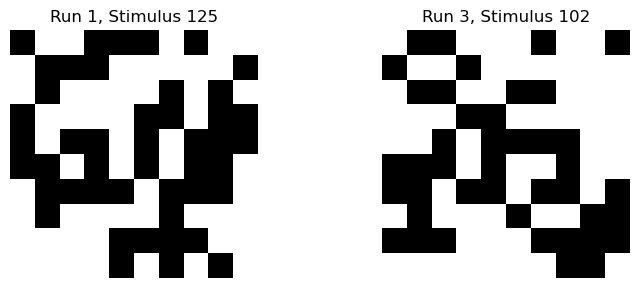

In [5]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(stimuli[0][124], interpolation="nearest", cmap="gray")
plt.axis("off")
plt.title("Run 1, Stimulus 125")
plt.subplot(1, 2, 2)
plt.imshow(stimuli[2][101], interpolation="nearest", cmap="gray")
plt.axis("off")
plt.title("Run 3, Stimulus 102")
plt.subplots_adjust(wspace=0.5)

In [6]:
fmri_data = np.vstack([fmri_run[2:] for fmri_run in fmri_data])
stimuli = np.vstack([stimuli_run[:-2] for stimuli_run in stimuli]).astype(
    float
)
print(fmri_data.shape)

(2860, 5438)


In [7]:
# Flatten the stimuli
stimuli = np.reshape(stimuli, (-1, stimulus_shape[0] * stimulus_shape[1]))

print(stimuli.shape)

(2860, 100)


In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

estimator = Ridge(alpha=100.0)
cv = KFold(n_splits=10)

scores = []
for train, test in cv.split(X=stimuli):
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = estimator.fit(
        stimuli.reshape(-1, 100)[train], fmri_data[train]
    ).predict(stimuli.reshape(-1, 100)[test])
    # we compute how much variance our encoding model explains in each voxel
    scores.append(
        r2_score(fmri_data[test], predictions, multioutput="raw_values")
    )

In [9]:
from nilearn.image import threshold_img

cut_score = np.mean(scores, axis=0)
cut_score[cut_score < 0] = 0

# bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(cut_score)

thresholded_score_map_img = threshold_img(
    score_map_img, threshold=1e-6, copy=False, copy_header=True
)

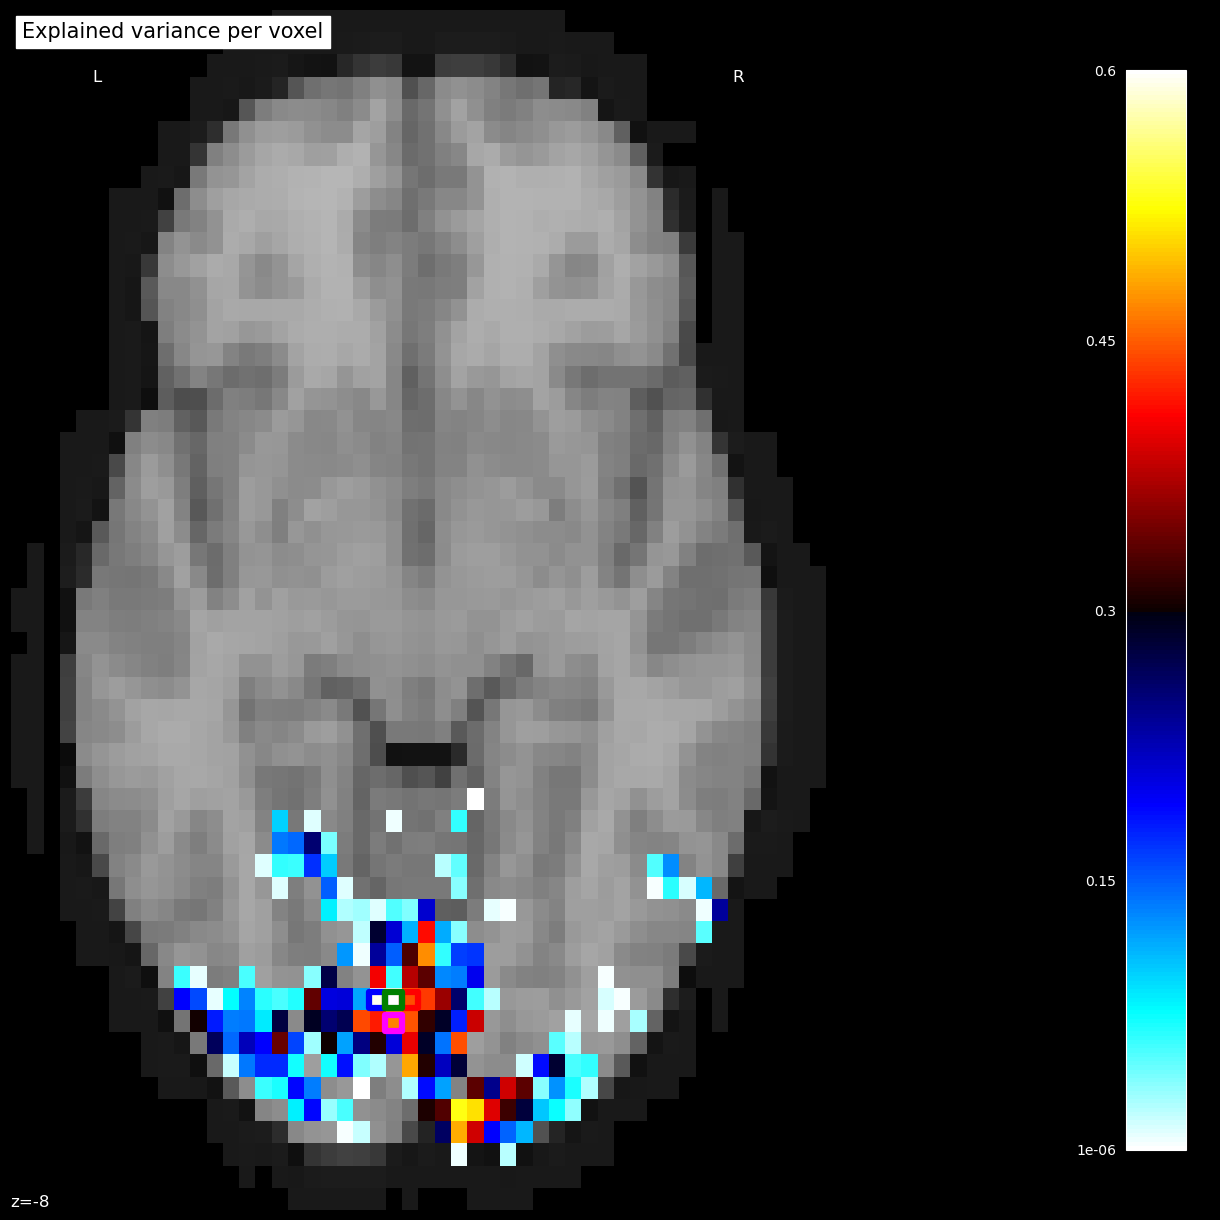

In [10]:
from nilearn.image import coord_transform
from nilearn.plotting import plot_stat_map


def index_to_xy_coord(x, y, z=10):
    """Transform data index to coordinates of the background + offset."""
    coords = coord_transform(x, y, z, affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(
    thresholded_score_map_img,
    bg_img=dataset.background,
    cut_coords=[-8],
    display_mode="z",
    aspect=1.25,
    title="Explained variance per voxel",
)

# creating a marker for each voxel and adding it to the statistical map

for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(
        index_to_xy_coord(x, y),
        marker_color="none",
        edgecolor=["b", "r", "magenta", "g"][i],
        marker_size=140,
        marker="s",
        facecolor="none",
        lw=4.5,
    )


# re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(12, 12)

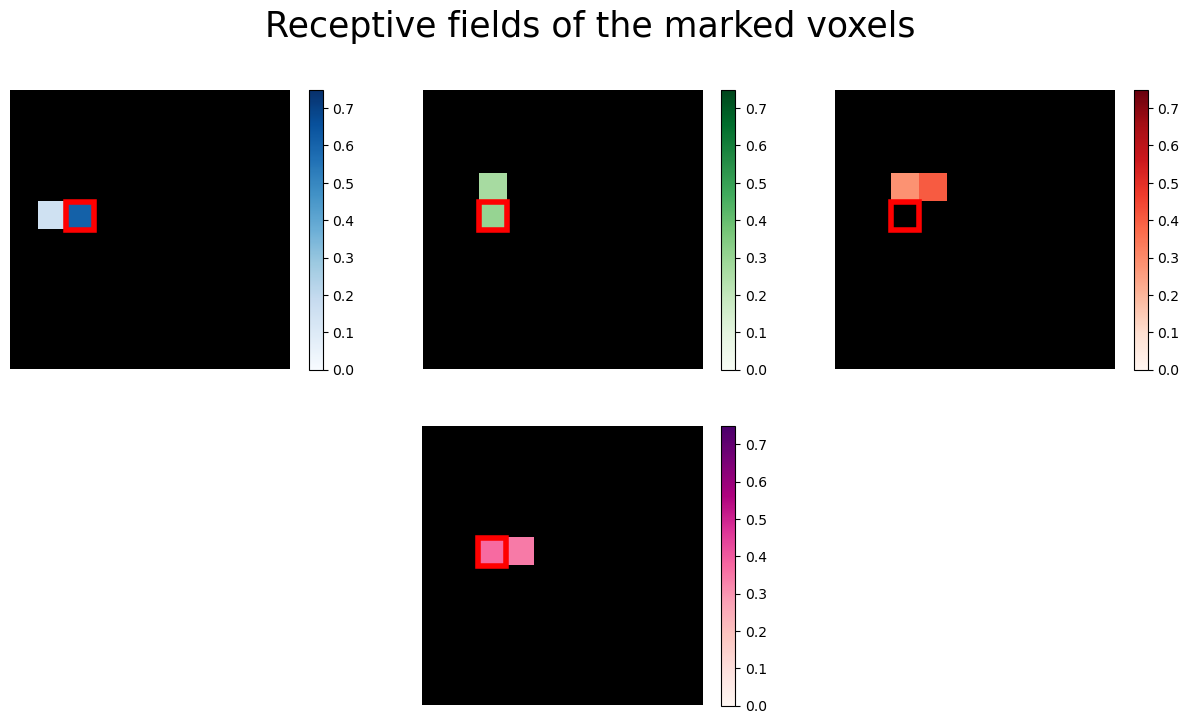

In [11]:
from sklearn.linear_model import LassoLarsCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# automatically estimate the sparsity by cross-validation

lasso = make_pipeline(StandardScaler(), LassoLarsCV(max_iter=10))

# Mark the same pixel in each receptive field
marked_pixel = (4, 2)

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle("Receptive fields of the marked voxels", fontsize=25)

# GridSpec allows us to do subplots with more control of the spacing
gs1 = gridspec.GridSpec(2, 3)

# we fit the Lasso for each of the three voxels of the upper row
for i, index in enumerate([1780, 1951, 2131]):
    ax = plt.subplot(gs1[0, i])
    lasso.fit(stimuli, fmri_data[:, index])
    # we reshape the coefficients into the form of the original images
    rf = lasso.named_steps["lassolarscv"].coef_.reshape((10, 10))
    # add a black background
    ax.imshow(np.zeros_like(rf), vmin=0.0, vmax=1.0, cmap="gray")
    ax_im = ax.imshow(
        np.ma.masked_less(rf, 0.1),
        interpolation="nearest",
        cmap=["Blues", "Greens", "Reds"][i],
        vmin=0.0,
        vmax=0.75,
    )
    # add the marked pixel
    ax.add_patch(
        Rectangle(
            (marked_pixel[1] - 0.5, marked_pixel[0] - 0.5),
            1,
            1,
            facecolor="none",
            edgecolor="r",
            lw=4,
        )
    )
    plt.axis("off")
    plt.colorbar(ax_im, ax=ax)

# and then for the voxel at the bottom

gs1.update(left=0.0, right=1.0, wspace=0.1)
ax = plt.subplot(gs1[1, 1])
lasso.fit(stimuli, fmri_data[:, 1935])
# we reshape the coefficients into the form of the original images
rf = lasso.named_steps["lassolarscv"].coef_.reshape((10, 10))
ax.imshow(np.zeros_like(rf), vmin=0.0, vmax=1.0, cmap="gray")
ax_im = ax.imshow(
    np.ma.masked_less(rf, 0.1),
    interpolation="nearest",
    cmap="RdPu",
    vmin=0.0,
    vmax=0.75,
)

# add the marked pixel
ax.add_patch(
    Rectangle(
        (marked_pixel[1] - 0.5, marked_pixel[0] - 0.5),
        1,
        1,
        facecolor="none",
        edgecolor="r",
        lw=4,
    )
)
plt.axis("off")
plt.colorbar(ax_im, ax=ax)